In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models

import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import cv2

import time
import copy
from barbar import Bar

import utils.imageTransformation as it

## Dataset Import

In [2]:
IMAGE_FOLDER = "Dataset/images/" 
meta_Dataframe = pd.read_csv("Dataset/info.csv")

In [3]:
print(meta_Dataframe.head())

             Namefile  Species   bbxmin   bbymin   bbxmax   bbymax
0    Abyssinian_1.jpg      cat      333       72      425      158
1   Abyssinian_10.jpg      cat       72      105      288      291
2  Abyssinian_100.jpg      cat      151       71      335      267
3  Abyssinian_101.jpg      cat       54       36      319      235
4  Abyssinian_102.jpg      cat       23       27      325      320


In [4]:
def getinfo(meta_Dataframe, imgind):
    return meta_Dataframe.iloc[imgind, 0], meta_Dataframe.iloc[imgind, 1], np.array([meta_Dataframe.iloc[imgind, 2],meta_Dataframe.iloc[imgind, 3],meta_Dataframe.iloc[imgind, 4],meta_Dataframe.iloc[imgind, 5]])

def show_bndbox(image, label, bndboxinfo, color = (0,255,0)):
    left = bndboxinfo[0]
    top = bndboxinfo[1]
    right = bndboxinfo[2]
    bottom = bndboxinfo[3]
    imgHeight, imgWidth, _ = image.shape
    thick = int((imgHeight + imgWidth) // 900)
    
    cv2.rectangle(image,(left, top), (right, bottom), color, thick)
    cv2.putText(image, label, (left, top - 12), 0, 1e-3 * imgHeight, color, thick//3)
    
    plt.axis("off")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    #plt.imshow(image)
    plt.show()

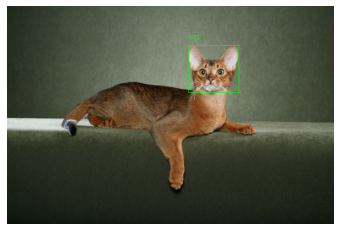

In [5]:
filename, label, bndboxinfo = getinfo(meta_Dataframe, 0)
path_file=IMAGE_FOLDER + filename

image = cv2.imread(path_file)
show_bndbox(image, label, bndboxinfo)

## Dataset

In [6]:
class RaceDogsCatsBNBDataset(Dataset):
    def __init__(self, csv_file, image_dir, label, transforms=None):
        self.info = pd.read_csv(csv_file)
        self.images = image_dir
        self.transforms = transforms
        self.encodelabel = {}
        self.reverselabel = {}
        for i, lab in enumerate(label):
            self.encodelabel[lab] = i
            self.reverselabel[i] = lab
            
    def __len__(self):
        return len(self.info)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        filename, label, bndbox = getinfo(self.info, idx)

        image = cv2.imread(self.images + filename)
        
        sample = {'image': image, 'bndbox': bndbox, 'label': self.encodelabel[label]}
        

        if self.transforms:
            sample = self.transforms(sample)
        
        return sample

## Transform Compose

In [7]:
composed = transforms.Compose([it.Rescale((256,256)),
                               it.ToTensor(),
                              ])

In [8]:
transformed_dataset = RaceDogsCatsBNBDataset(csv_file = "Dataset/info.csv",
                                             image_dir = IMAGE_FOLDER,
                                             transforms = composed,
                                             label =['cat', 'dog'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 torch.Size([3, 256, 256]) torch.Size([4]) 0


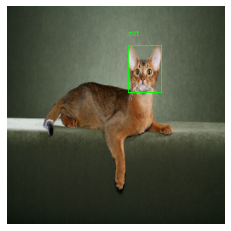

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 torch.Size([3, 256, 256]) torch.Size([4]) 0


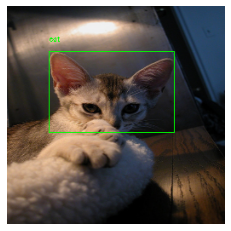

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 torch.Size([3, 256, 256]) torch.Size([4]) 0


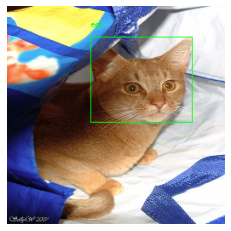

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 torch.Size([3, 256, 256]) torch.Size([4]) 0


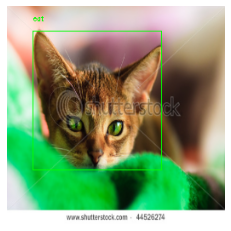

In [9]:
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['bndbox'].size(), sample['label'])
    image = (sample['image'].numpy()).transpose((1,2,0))
    show_bndbox(image, transformed_dataset.reverselabel[sample['label']], sample['bndbox'])
    if i == 3:
        break

In [10]:
train_size = int(0.7 * len(transformed_dataset))
test_size = len(transformed_dataset) - train_size

Train_Dataset, Test_Dataset = torch.utils.data.random_split(transformed_dataset, [train_size, test_size])

dataset_sizes = {'train': len(Train_Dataset), 'eval': len(Test_Dataset)}

In [11]:
Train_Loader = DataLoader(Train_Dataset, batch_size = 4, shuffle = True, num_workers = 4)
Test_Loader = DataLoader(Test_Dataset, batch_size = 4, shuffle = False, num_workers = 4)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.alexnet = models.alexnet(pretrained=True)
        for param in self.alexnet.parameters():
            param.requires_grad = False
        self.fc1 = nn.Linear(1000, 500)
        self.fc2 = nn.Linear(500, 100)
        
        self.fc3 = nn.Linear(100, 50)
        self.fc4 = nn.Linear(50, 10)
        self.fc5 = nn.Linear(10, 2)
        
        self.fc6 = nn.Linear(100, 50)
        self.fc7 = nn.Linear(50, 4)
        
    def forward(self, x):
        x = torch.sigmoid(self.alexnet(x.float()))
        x = torch.relu(self.fc1(x))
        x1 = torch.relu(self.fc2(x))
        
        x = F.relu(self.fc3(x1))
        x = F.relu(self.fc4(x))
        label = F.log_softmax(self.fc5(x))
        
        x = F.relu(self.fc6(x1))
        bndbox = F.relu(self.fc7(x))
        return [label ,bndbox]
    
class MultiTaskLossWrapper(nn.Module):
    def __init__(self, task_num):
        super(MultiTaskLossWrapper, self).__init__()

    def forward(self, preds, label, bndbox):        
        CE = nn.CrossEntropyLoss()
        MSE = nn.MSELoss(reduction = 'sum')
        loss0 = CE(preds[0], label)
        loss1 = MSE(bndbox / 256., preds[1])
        alpha = 0.5
        loss = alpha*loss0 + (1-alpha)*loss1
        return loss

In [14]:
net = Net().to(device)
criterion = MultiTaskLossWrapper(2).to(device)

In [15]:
optimizer_ft = optim.SGD(net.parameters(), lr=0.01, momentum = 0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()
    
    # Copie des poids du réseau
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    #Parcours des epochs
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        #Parcours des deux phases
        for phase in ['train', 'eval']:
            if phase == 'train':
                model.train()
                dataload = Train_Loader
            else:
                model.eval()
                dataload = Test_Loader
            
            running_loss = 0.0
            running_corrects = 0
                        
            #Parcours du dataload, divisé par les batch
            for idx, batch in enumerate(dataload):
                # Ligne cuda
                
                image = batch['image'].to(device)
                bndbox = batch['bndbox'].to(device)
                labels = batch['label'].to(device)

                optimizer.zero_grad()
  
                with torch.set_grad_enabled(phase == 'train'):
                    #Sortie prédite
                    outputs = model(image)
                
                    #Calcul de la fonction de perte
                    loss = criterion(outputs, labels, bndbox)

                    _, preds = torch.max(outputs[0], 1)
                    
                    #Backpropagation
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * image.size(0)
                running_corrects += torch.sum(preds == labels) 
                
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase] 

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'eval' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [17]:
net = train_model(net, criterion, optimizer_ft, exp_lr_scheduler, num_epochs = 15)

Epoch 0/14
----------


<ipython-input-13-59d31866d633>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  label = F.log_softmax(self.fc5(x))


train Loss: 0.4743 Acc: 0.6857
eval Loss: 0.3555 Acc: 0.8463

Epoch 1/14
----------
train Loss: 0.3527 Acc: 0.8287
eval Loss: 0.3122 Acc: 0.8897

Epoch 2/14
----------
train Loss: 0.3247 Acc: 0.8457
eval Loss: 0.2827 Acc: 0.8933

Epoch 3/14
----------
train Loss: 0.3104 Acc: 0.8694
eval Loss: 0.2659 Acc: 0.9051

Epoch 4/14
----------
train Loss: 0.3002 Acc: 0.8628
eval Loss: 0.2606 Acc: 0.9014

Epoch 5/14
----------
train Loss: 0.2835 Acc: 0.8798
eval Loss: 0.2534 Acc: 0.9069

Epoch 6/14
----------
train Loss: 0.2887 Acc: 0.8787
eval Loss: 0.2736 Acc: 0.8870

Epoch 7/14
----------
train Loss: 0.2467 Acc: 0.9012
eval Loss: 0.2435 Acc: 0.9005

Epoch 8/14
----------
train Loss: 0.2442 Acc: 0.8957
eval Loss: 0.2353 Acc: 0.9159

Epoch 9/14
----------
train Loss: 0.2371 Acc: 0.9066
eval Loss: 0.2322 Acc: 0.9195

Epoch 10/14
----------
train Loss: 0.2398 Acc: 0.8973
eval Loss: 0.2311 Acc: 0.9204

Epoch 11/14
----------
train Loss: 0.2324 Acc: 0.9143
eval Loss: 0.2301 Acc: 0.9168

Epoch 12/14


<ipython-input-13-59d31866d633>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  label = F.log_softmax(self.fc5(x))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cat


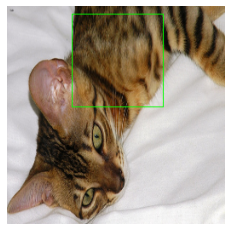

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dog


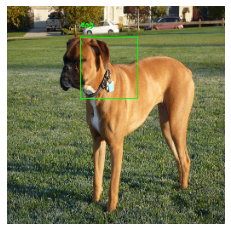

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dog


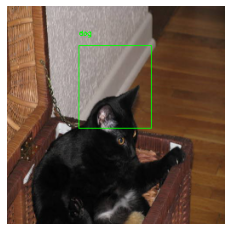

dog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


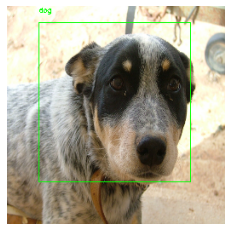

In [19]:
import random
for i in range(4):
    y = transformed_dataset[random.randint(0, 2580)]
    image2 = (y['image'].numpy()).transpose((1,2,0))

    label, bndbox = net(y['image'].unsqueeze(0).to(device))

    _, preds = torch.max(label, 1)

    pred = preds[0].cpu()
    bnd = (bndbox[0] * 256.).int().cpu()
    print(transformed_dataset.reverselabel[pred.item()])
    show_bndbox(image2, transformed_dataset.reverselabel[pred.item()], bnd)